In [ ]:
!pip install odeformer --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.4.1 which is incompatible.
torchvision 0.20.1+cu121 requires torch==2.5.1, but you have torch 2.4.1 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestRegressor
from functools import partial
from odeformer.model import SymbolicTransformerRegressor
from odeformer.metrics import r2_score

In [ ]:
# Initialize and Configure ODEFormer Model
def initialize_model():
    """Initialize the SymbolicTransformerRegressor model with predefined arguments."""
    model = SymbolicTransformerRegressor(from_pretrained=True)
    model_args = {'beam_size': 50, 'beam_temperature': 0.1}
    model.set_model_args(model_args)
    return model

In [ ]:
# Generate Synthetic Data
def generate_trajectory():
    """Generate a sample trajectory for testing."""
    times = np.linspace(0, 10, 25)
    x = 2.3 * np.cos(times + 0.5)
    y = 1.2 * np.sin(times + 0.1)
    trajectory = np.stack([x, y], axis=1)
    return times, trajectory

In [ ]:
# Fit Model and Predict
def fit_and_predict(model, times, trajectory):
    """Fit the model on the trajectory and predict outputs."""
    candidates = model.fit(times, trajectory)
    model.print(n_predictions=1)
    pred_trajectory = model.predict(times, trajectory[0])
    return pred_trajectory

In [ ]:
# Custom Metrics for Model Performance
def calculate_metrics(true_trajectory, predicted_trajectory, times):
    """Calculate R2 score, MAE, and trajectory divergence."""
    # R2 Score
    r2 = r2_score(true_trajectory, predicted_trajectory)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(true_trajectory - predicted_trajectory))

    # Trajectory Divergence (Integral of Absolute Differences)
    trajectory_divergence = np.trapz(
        np.sum(np.abs(true_trajectory - predicted_trajectory), axis=1),
        times
    )

    print("Model Performance Metrics:")
    print(f"R2 Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Trajectory Divergence: {trajectory_divergence:.4f}")

    return r2, mae, trajectory_divergence

In [ ]:
# Visualization of True vs Predicted Trajectories
def plot_trajectories(times, trajectory, pred_trajectory):
    """Plot true and predicted trajectories for comparison."""
    plt.plot(times, trajectory[:, 0], label='True X')
    plt.plot(times, pred_trajectory[:, 0], label='Predicted X', linestyle='--')
    plt.plot(times, trajectory[:, 1], label='True Y')
    plt.plot(times, pred_trajectory[:, 1], label='Predicted Y', linestyle='--')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Trajectory')
    plt.title('True vs Predicted Trajectories')
    plt.show()

In [ ]:
# Define Prediction Wrapper for SHAP
def predict_initial_state(initial_states, model, times):
    """Predict trajectories for initial states using the model."""
    preds = []
    failed_predictions = []

    for i, state in enumerate(initial_states):
        pred = model.predict(times, state.ravel())
        if pred is not None:
            preds.append(pred.ravel())
        else:
            failed_predictions.append((i, state))
            preds.append(np.nan * np.zeros(len(times) * 2))

    if failed_predictions:
        print("Warning: Predictions failed for the following states:")
        for index, state in failed_predictions:
            print(f"  Index: {index}, State: {state}")

    return np.array(preds)

In [ ]:
# SHAP Analysis
def shap_analysis(model, times, trajectory):
    """Perform SHAP analysis on the model predictions with expanded background data and plot time-dependent effects."""
    # Use multiple points along the trajectory as background data
    background = trajectory[:5]  # First 5 points as representative background
    explainer = shap.KernelExplainer(
        lambda states: predict_initial_state(states, model, times),
        background
    )
    shap_values = explainer.shap_values(background)

    # Aggregate SHAP values across features
    aggregated_shap = np.mean(np.abs(shap_values[0]), axis=1)
    shap.summary_plot(
        aggregated_shap.reshape(1, -1),
        background,
        feature_names=['Initial X', 'Initial Y'],
        plot_type='bar'
    )

    # Plot SHAP values across time for individual dimensions
    time_steps = range(shap_values[0].shape[0])
    for dim, name in enumerate(['Initial X', 'Initial Y']):
        plt.plot(time_steps, np.abs(shap_values[0][:, dim]), label=f'SHAP for {name}')
    plt.xlabel('Time Step')
    plt.ylabel('SHAP Value Magnitude')
    plt.title('SHAP Values Over Time for Each Dimension')
    plt.legend()
    plt.show()

In [ ]:
# Sensitivity Analysis
def sensitivity_analysis(model, times, trajectory):
    """Analyze the sensitivity of predictions to initial condition perturbations."""
    delta = 0.5
    perturbed_states = [
        trajectory[0] + np.array([delta, 0]),
        trajectory[0] + np.array([0, delta]),
    ]
    for state in perturbed_states:
        pred = model.predict(times, state.ravel())
        if pred is None:
            print(f"Prediction failed for perturbed state: {state}")
            continue
        plt.plot(times, pred[:, 0], label=f'Perturbed X (State: {state})')
        plt.plot(times, pred[:, 1], label=f'Perturbed Y (State: {state})')
    plt.legend()
    plt.title('Trajectory for Perturbed States')
    plt.xlabel('Time')
    plt.ylabel('Trajectory')
    plt.show()

In [ ]:
# Main Function
def main():
    """Main function to run the ODEFormer and SHAP analysis pipeline."""

    # Initialize model
    model = initialize_model()

    # Generate synthetic data
    times, trajectory = generate_trajectory()

    # Fit and predict
    pred_trajectory = fit_and_predict(model, times, trajectory)

    # Calculate and print custom metrics
    calculate_metrics(trajectory, pred_trajectory, times)

    # Plot trajectories
    plot_trajectories(times, trajectory, pred_trajectory)

    # Perform SHAP analysis
    shap_analysis(model, times, trajectory)

    # Perform sensitivity analysis
    sensitivity_analysis(model, times, trajectory)


Found pretrained model at odeformer.pt
Loaded pretrained model
x_0' = -2.9690 * x_1 + -1.9456 * sin(-0.0544 + 0.6603 * x_1)
x_1' = 0.3243 * x_0
Model Performance Metrics:
R2 Score: 0.3717
Mean Absolute Error (MAE): 0.7269
Trajectory Divergence: 14.4978


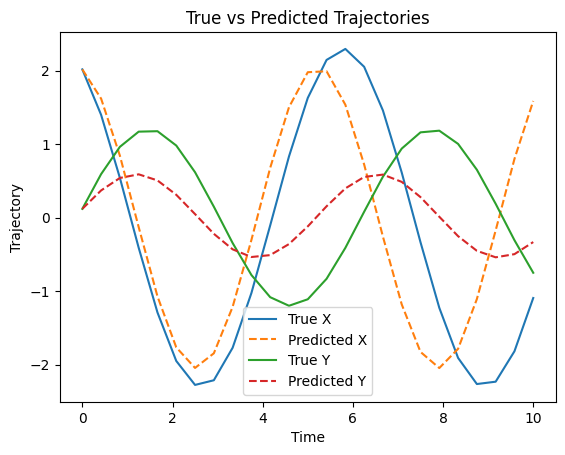

  0%|          | 0/5 [00:00<?, ?it/s]

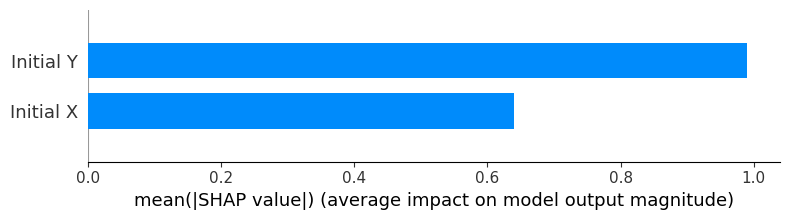

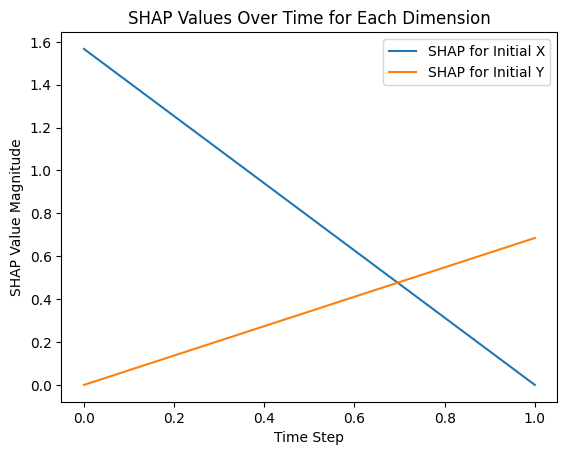

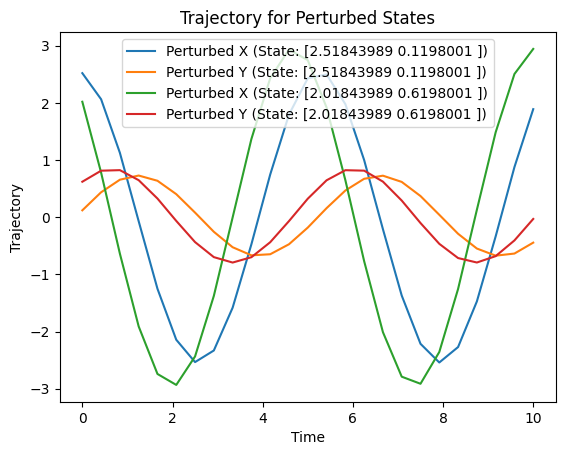

In [ ]:
if __name__ == "__main__":
    main()